# Polyelectrophysiology Signal Processing

This notebook is an exercise in processing and interpreting electrophysiologiacal signals.


## Introduction
**Electrophysiology** studies the electrical properties of biological tissues. For example (conductive) electrodes in contact with tissues interact creating a potential difference (voltage)that can be measured, amplified and/or filtered digitized and analyzed.

Many physiological systems have have electrical artifacts that we can measure including muscles, heartbeats, brain activity, and even things like chills, central pattern generators any much more. The difficulty is usually in distinguishing the signal from the noise, and in interpreting the signal.

The raw electrical signals (voltage readings) typically need to me cleaned and denoised. For example, we may want to remove certain frequencies (like from 60Hz power grid) or examine only specific frequencies (like a .5-40 Hz range for brain activity, 20-450 Hz for muscle activity, .5-100 Hz for heartbeat shape). Or we may wan to examine how the signal(s) change given an event/stimulus. Basically here are the questions we can ask to examine/analyze a raw signal:

- Are there specific frequencies or trends I'd like to remove because I know they are contaminating or not useful?
    Eg. 60Hz power line noise, DC offset causing slow constant voltage shits

- What frequencies are present in my signal over time and how strong are they?

- What artifacts are present?

- How strong is the signal over time or on average? How much does the signal fluctuate around average? How frequently does it flip sign? How unpredictable is it (entropy)?


In [1]:
%matplotlib inline

In [22]:
import numpy as np
from matplotlib import pyplot as plt
import neurokit2 as nk
import seaborn as sns

## Biosignal with Events

In [3]:
# Data: 2.5 minutes of biosignals recorded at a frequency of 100Hz (2.5 x 60 x 100 = 15000 data points); 1 participant saw 4 emotional and neutral images (events)
# Biosignals : ECG, RSP, EDA + Photosensor (event signal)
# https://neuropsychology.github.io/NeuroKit/examples/bio_eventrelated/bio_eventrelated.html?utm_source=chatgpt.com
data = nk.data("bio_eventrelated_100hz")
data

,ECG,EDA,Photosensor,RSP
0,-0.015869,13.196868,5.0,0.778931
1,-0.011703,13.197173,5.0,0.777588
2,-0.009766,13.197020,5.0,0.777435
3,-0.013321,13.197631,5.0,0.777557
4,-0.009583,13.196715,5.0,0.775299
...,...,...,...,...
14995,-0.007675,14.873656,5.0,1.351868
14996,-0.005203,14.873961,5.0,1.356689
14997,-0.004272,14.874266,5.0,1.361938
14998,-0.000458,14.875335,5.0,1.366821


### Visualize Signals and Plot Events

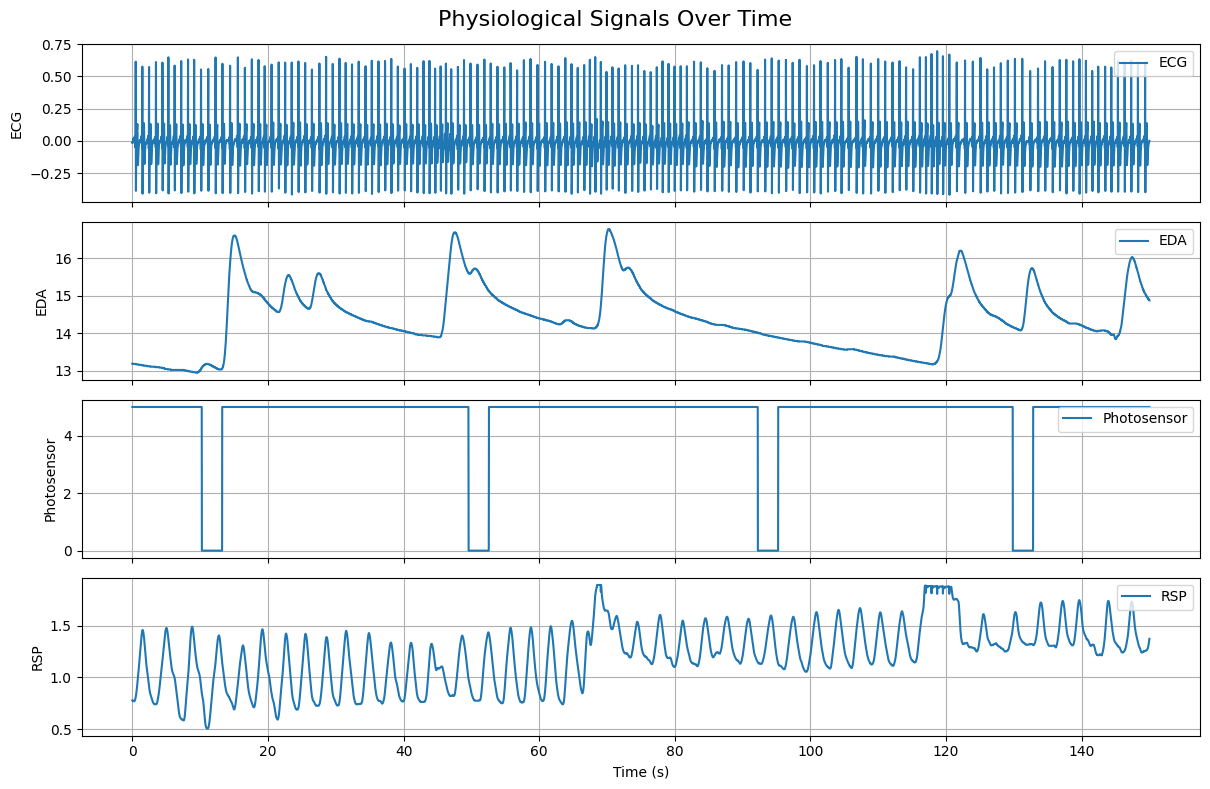

In [4]:
import matplotlib.pyplot as plt

# Create time vector
sampling_rate = 100  # Hz
time = data.index / sampling_rate  # seconds

# Set up side-by-side plots
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Plot each signal
signals = ["ECG", "EDA", "Photosensor", "RSP"]
for i, signal in enumerate(signals):
    axes[i].plot(time, data[signal], label=signal)
    axes[i].set_ylabel(signal)
    axes[i].legend(loc="upper right")
    axes[i].grid(True)

# Set x-label only on the last plot
axes[-1].set_xlabel("Time (s)")

plt.suptitle("Physiological Signals Over Time", fontsize=16)
plt.tight_layout()
plt.show()

{'RSP_Peaks': array([  502,   881,  1275,  1631,  1917,  2268,  2555,  2864,  3154,
        3489,  3812,  4110,  4412,  4865,  5250,  5578,  5877,  6170,
        6482,  6862,  7448,  7783,  8117,  8453,  8769,  9087,  9418,
        9747, 10089, 10415, 10731, 11030, 11349, 11694, 12553, 13023,
       13398, 13721, 13965, 14394]), 'RSP_Troughs': array([  347,   754,  1105,  1501,  1792,  2141,  2430,  2731,  3032,
        3310,  3685,  3991,  4286,  4693,  5065,  5454,  5756,  6056,
        6350,  6638,  7341,  7658,  7993,  8333,  8566,  8964,  9270,
        9612,  9937, 10288, 10606, 10906, 11221, 11547, 12451, 12872,
       13291, 13618, 13865, 14242]), 'sampling_rate': 100}


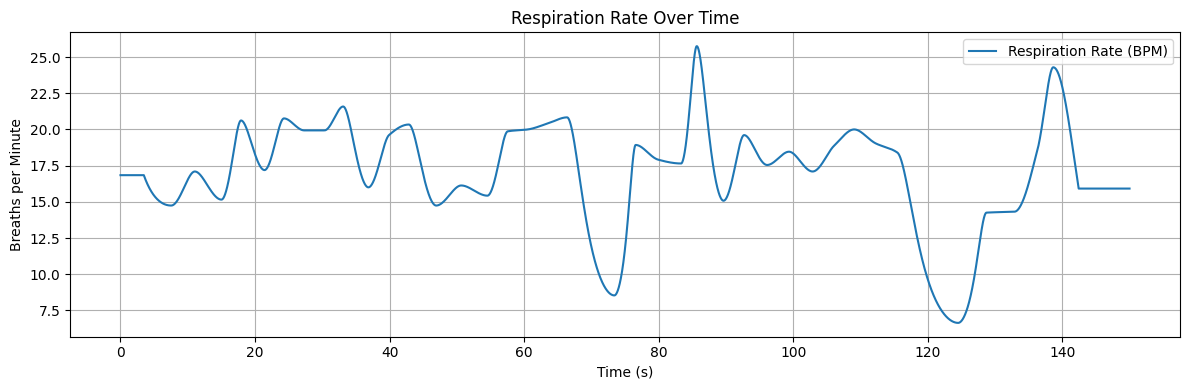

In [5]:
# lets answer some basic questions: whats their respiration rate over time? And plot it.
rsp_signal = data["RSP"]

# Step 1: Process the respiration signal
# this pipeline cleans the signal (low pass filter 3Hz cutoff, removes noise, fluctuations, artifacts), detects peaks, calculates phase, estimates rate)
rsp_processed, rsp_info = nk.rsp_process(rsp_signal, sampling_rate=100)
print(rsp_info)

# Step 2: Extract instantaneous respiration rate (breaths per minute)
rsp_rate = rsp_processed["RSP_Rate"]

# Step 3: Create time vector
time = rsp_processed.index / 100  # seconds

# Step 4: Plot respiration rate over time
plt.figure(figsize=(12, 4))
plt.plot(time, rsp_rate, label="Respiration Rate (BPM)")
plt.xlabel("Time (s)")
plt.ylabel("Breaths per Minute")
plt.title("Respiration Rate Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
ecg_signal = data["ECG"]
sampling_rate = 100
ecg_processed, ecg_info = nk.ecg_process(ecg_signal, sampling_rate=sampling_rate)

r_peaks = ecg_info["ECG_R_Peaks"]  # These are the sample indices of R-peaks
time = ecg_processed.index / sampling_rate

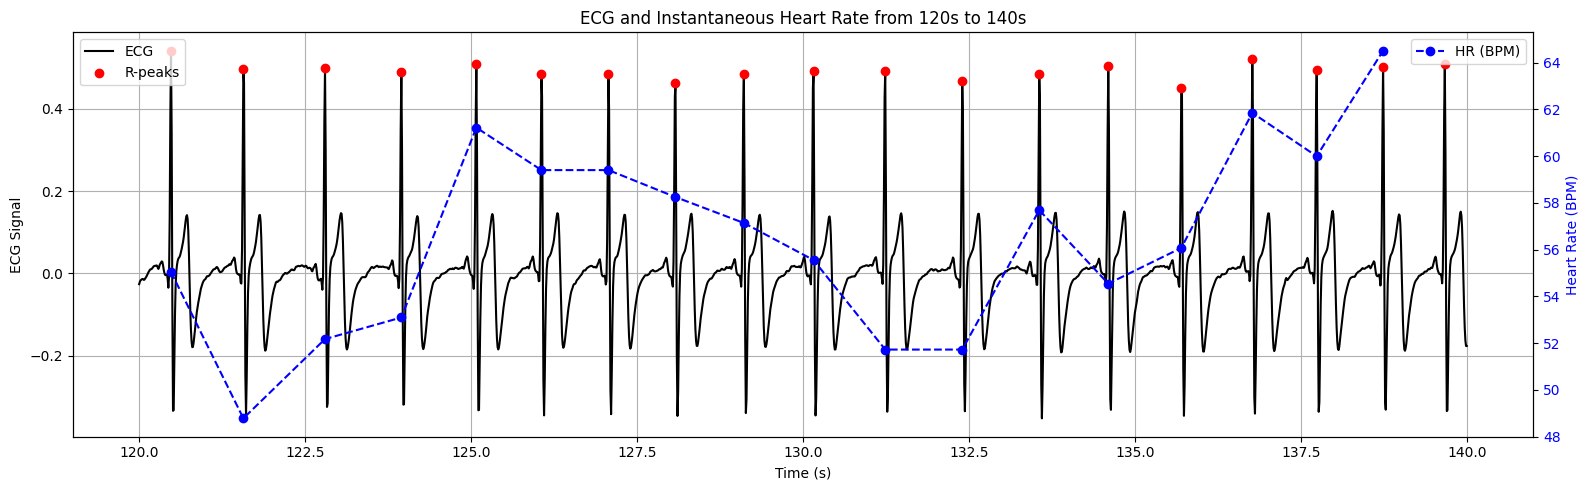

In [12]:
# Define zoom window
start_sec = 120
end_sec = 140
mask = (time >= start_sec) & (time <= end_sec)

ecg_clean = ecg_processed["ECG_Clean"]

# Filter data for plotting
time_zoom = time[mask]
ecg_zoom = ecg_clean[mask]

# R-peaks in the window
r_peaks_zoom = [rp for rp in r_peaks if start_sec <= rp / sampling_rate <= end_sec]
r_peak_times = np.array(r_peaks_zoom) / sampling_rate
r_peak_values = ecg_clean.iloc[r_peaks_zoom]

# RR intervals and HR (BPM)
rr_intervals = np.diff(r_peaks_zoom) / sampling_rate
rr_times = np.array(r_peaks_zoom[:-1]) / sampling_rate
hr_bpm = 60 / rr_intervals

# Plot
fig, ax1 = plt.subplots(figsize=(16, 5))

# ECG + R-peaks
ax1.plot(time_zoom, ecg_zoom, label="ECG", color="black")
ax1.scatter(r_peak_times, r_peak_values, color="red", label="R-peaks", zorder=3)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("ECG Signal")
ax1.grid(True)
ax1.legend(loc="upper left")

# Heart rate on secondary axis
ax2 = ax1.twinx()
ax2.plot(rr_times, hr_bpm, color="blue", linestyle="--", marker="o", label="HR (BPM)")
ax2.set_ylabel("Heart Rate (BPM)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.legend(loc="upper right")

plt.title(f"ECG and Instantaneous Heart Rate from {start_sec}s to {end_sec}s")
plt.tight_layout()
plt.show()

Mark events from the photosensor channel using the events_find function.

In [13]:
# Finds event onsets based on a signal and a threshold.
# events_find(event channel, look for dips below level, event labels)
condition_list = ["Negative", "Neutral", "Neutral", "Negative"]
events = nk.events_find(
    data["Photosensor"], threshold_keep="below", event_conditions=condition_list
)
events

{'onset': array([ 1024,  4957,  9224, 12984]),
 'duration': array([300, 300, 300, 300]),
 'label': array(['1', '2', '3', '4'], dtype='<U21'),
 'condition': ['Negative', 'Neutral', 'Neutral', 'Negative']}

Mark the events

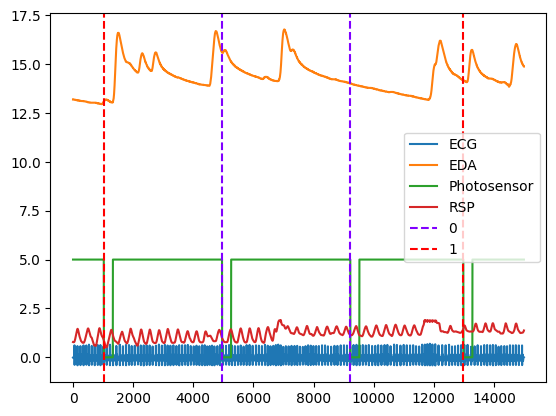

In [14]:
# Plot the location of event with the signals
plot = nk.events_plot(events, data)

### Process Signals

Process the biosignals using nks predefined pipelines for ECG, etc. (this does the cleaning, denoising, etc.)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

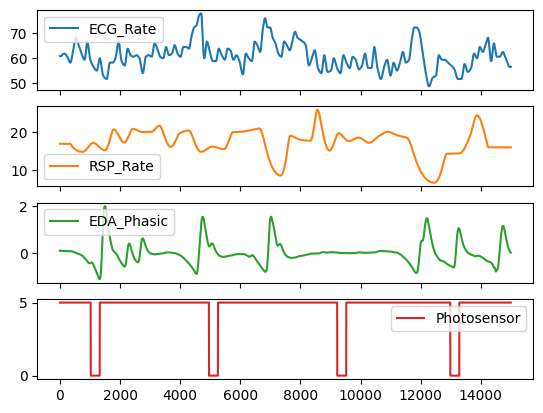

In [15]:
data_clean, info = nk.bio_process(
    ecg=data["ECG"],
    rsp=data["RSP"],
    eda=data["EDA"],
    keep=data["Photosensor"],
    sampling_rate=100,
)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", "EDA_Phasic", "Photosensor"]].plot(subplots=True)

### Examine Event-Related Features

In [16]:
# transform dataframe into epochs, i.e. segments (chunks) of data around the events. We want it to start 1 second before the event onset and end 6 seconds after
epochs = nk.epochs_create(
    data_clean, events, sampling_rate=100, epochs_start=-1, epochs_end=6
)

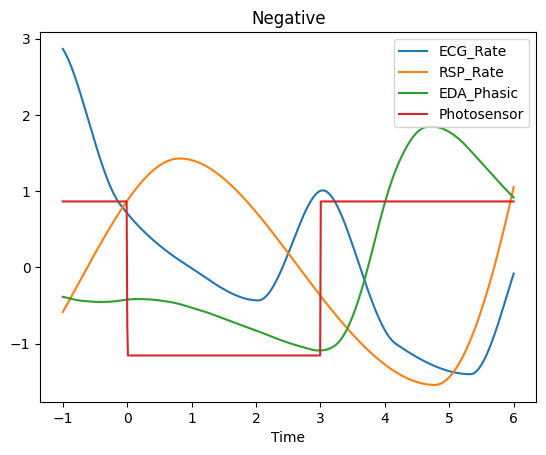

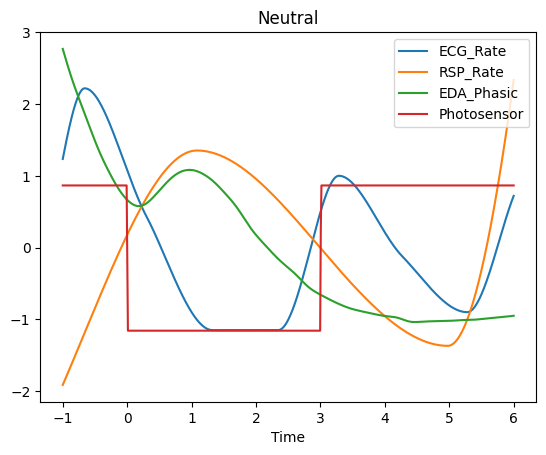

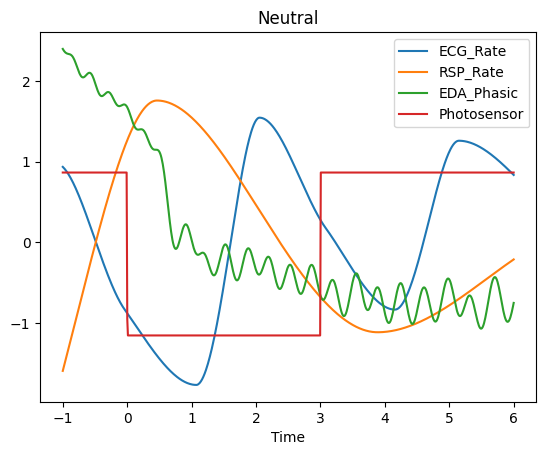

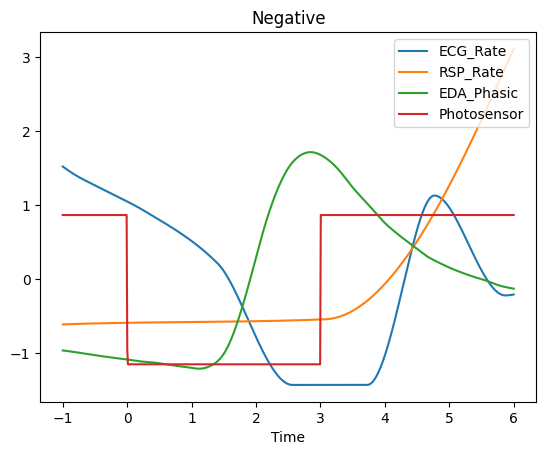

In [17]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals
    nk.signal_plot(
        epoch[["ECG_Rate", "RSP_Rate", "EDA_Phasic", "Photosensor"]],
        title=epoch["Condition"].values[0],  # Extract condition name
        standardize=True,
    )

In [18]:
# Extract event-related features manually or using bio_analyze pipeline
df = nk.bio_analyze(epochs, sampling_rate=100)
df

,Label,Condition,Event_Onset,ECG_Rate_Baseline,ECG_Rate_Max,ECG_Rate_Min,ECG_Rate_Mean,ECG_Rate_SD,ECG_Rate_Max_Time,ECG_Rate_Min_Time,...,RSP_RVT_Baseline,RSP_RVT_Mean,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime,RSA_P2T,RSA_Gates
1,1,Negative,1024,58.962843,1.037157,-7.238706,-3.416404,2.462046,3.035765,5.329041,...,0.225643,-0.037677,1.995617,1,3.114808,4.718169,1.74,NaN,-56.170030,1.776357e-15
2,2,Neutral,4957,64.000846,-0.056683,-5.177317,-3.209327,1.661333,0.011445,1.323319,...,0.169809,0.019351,0.868942,0,NaN,NaN,NaN,NaN,-43.273326,-7.601609e-02
3,3,Neutral,9224,55.976284,5.248206,-1.922230,1.891089,2.279224,2.054363,1.072961,...,0.127095,0.017846,0.026651,0,NaN,NaN,NaN,NaN,-13.138628,1.358487e-01
4,4,Negative,12984,57.505912,0.186396,-5.781774,-2.941543,2.142268,4.768240,2.565093,...,0.080601,0.012434,1.056855,1,1.675922,2.845494,1.73,1.93,-24.326239,1.843122e-01


<Axes: xlabel='Condition', ylabel='ECG_Rate_Mean'>

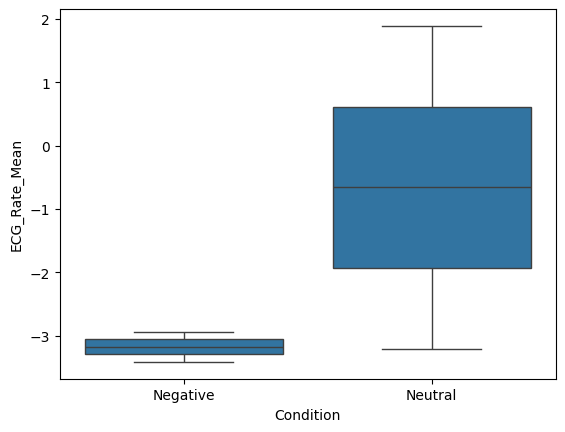

In [19]:
import seaborn as sns

sns.boxplot(x="Condition", y="ECG_Rate_Mean", data=df)

Negative stimuli, as compared to neutral stimuli, show stronger cardiac deceleration (i.e., higher heart rate variability).

<Axes: xlabel='Condition', ylabel='RSP_Rate_Mean'>

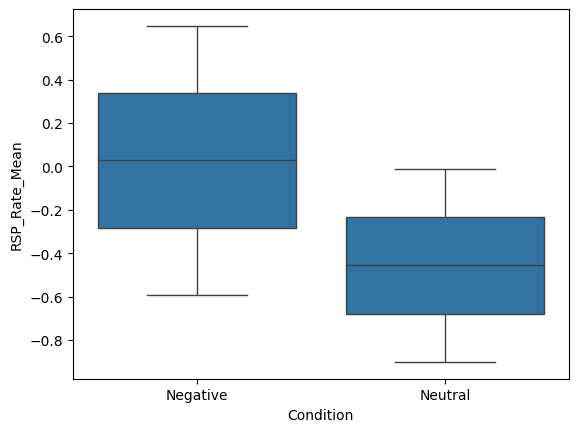

In [20]:
sns.boxplot(x="Condition", y="RSP_Rate_Mean", data=df)

Negative stimuli, as compared to neutral stimuli, show an accelerated breathing rate.

<Axes: xlabel='Condition', ylabel='EDA_Peak_Amplitude'>

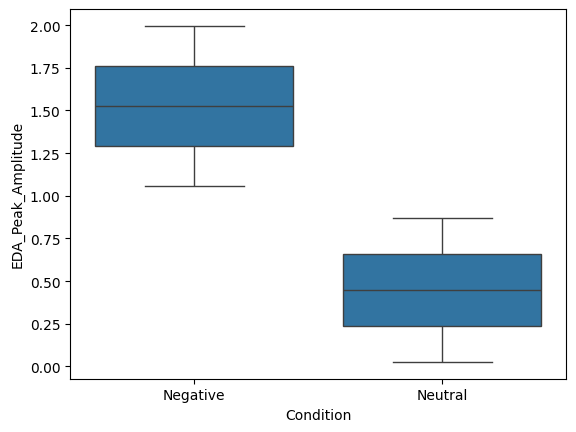

In [21]:
sns.boxplot(x="Condition", y="EDA_Peak_Amplitude", data=df)

Negative stimuli, as compared to neutral stimuli, show higher skin conductive response magnitude.

## Manual ECG Processing

We used a lot of nk pipelines for processing and cleaning but lets do the same thing manually with teh ECG signal to make sure we understand whats going on.

In [24]:
# here is the raw ecg signal and below it the cleaned version (from the nk pipeline) so we can see the difference
# also marked in the graphs are the events as 1s and 0s

import plotly.graph_objects as go

sampling_rate = 100
time = ecg_signal.index / sampling_rate

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=time,
        y=ecg_signal,
        mode="lines",
        name="Raw ECG",
        line=dict(color="gray", width=2),
    )
)
fig.add_trace(
    go.Scatter(
        x=time,
        y=ecg_clean,
        mode="lines",
        name="Cleaned ECG",
        line=dict(color="green", width=1),
    )
)

# Add event markers
for onset in events["onset"]:
    fig.add_vline(
        x=onset / sampling_rate, line_dash="dash", line_color="red", opacity=0.5
    )

fig.update_layout(
    title="Interactive ECG Viewer with Event Markers",
    xaxis_title="Time (s)",
    yaxis_title="Amplitude",
    height=400,
    showlegend=True,
)

fig.show()

### Is there any slow drift to isolate and remove?

In [ ]:
# isolate and visualize slow drift (anything less than .5 Hz) in the ECG signal
from scipy.signal import butter, filtfilt


def lowpass_filter(signal, cutoff, fs, order=4):
    nyq = fs / 2
    b, a = butter(order, cutoff / nyq, btype="low")
    return filtfilt(b, a, signal)


fs = 100  # Hz
drift = lowpass_filter(ecg_signal, cutoff=0.5, fs=fs)

In [ ]:
# Zoom window
start_sec = 20
end_sec = 30
mask = (ecg_signal.index / fs >= start_sec) & (ecg_signal.index / fs <= end_sec)

time_zoom = ecg_signal.index[mask] / fs
ecg_raw_zoom = ecg_signal[mask]
drift_zoom = drift[mask]

# Plot
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=time_zoom, y=ecg_raw_zoom, name="Raw ECG", line=dict(color="black", width=1)
    )
)
fig.add_trace(
    go.Scatter(
        x=time_zoom,
        y=drift_zoom,
        name="Slow Drift (<0.5 Hz)",
        line=dict(color="orange", width=2, dash="dot"),
    )
)

fig.update_layout(
    title="ECG with Slow Drift Component (< 0.5 Hz)",
    xaxis_title="Time (s)",
    yaxis_title="Amplitude",
    height=400,
)
fig.show()

In [29]:
import numpy as np

drift_std = np.std(drift)
print(f"Standard deviation of slow drift signal: {drift_std:.5f}")

Standard deviation of slow drift signal: 0.00132


In [30]:
from scipy.stats import linregress

fs = 100
time = np.arange(len(drift)) / fs
slope, intercept, r_value, p_value, std_err = linregress(time, drift)

print(f"Drift slope: {slope:.8f} units/sec")

Drift slope: 0.00000022 units/sec


### How much of the EGC signal’s power is contained in each frequency band?

Power Spectral Density shows how much energy is in different frequencies averaged over time.

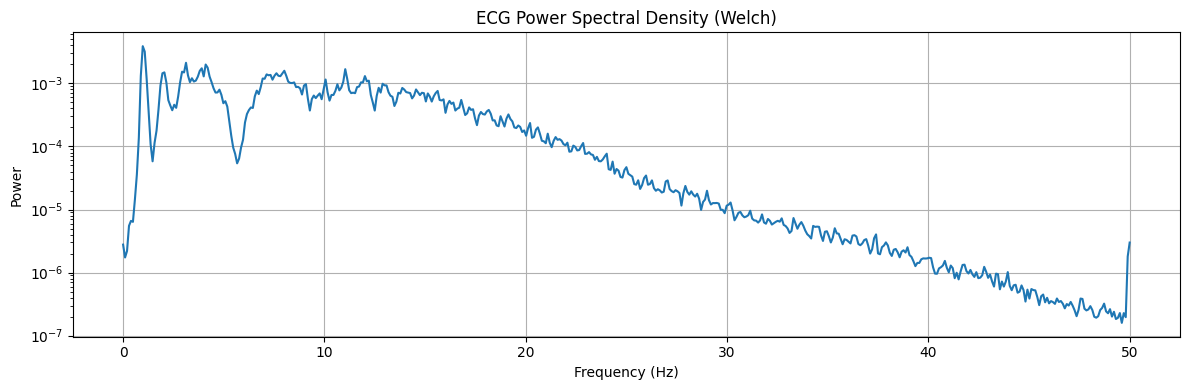

Power below 0.5 Hz: 0.0166% of total ECG signal power


In [28]:
from scipy.signal import welch
import numpy as np
import matplotlib.pyplot as plt

# Sampling rate
fs = 100

# Compute power spectral density using Welch's method
frequencies, psd = welch(ecg_signal.values, fs=fs, nperseg=1024)

# Plot full spectrum
plt.figure(figsize=(12, 4))
plt.semilogy(frequencies, psd)
plt.title("ECG Power Spectral Density (Welch)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.grid(True)
plt.tight_layout()
plt.show()

# Quantify power below 0.5 Hz
low_freq_mask = frequencies < 0.5
low_freq_power = np.sum(psd[low_freq_mask])
total_power = np.sum(psd)
percent_low_freq = 100 * low_freq_power / total_power

print(f"Power below 0.5 Hz: {percent_low_freq:.4f}% of total ECG signal power")

This also confirms that there is extremely low baseline drift...essentially negligable. But it doesn't hurt anything to filter it out in the cleaning process.

### Any power line contamination/noise (50 or 60 Hz)?

Unfortunately since the sampling rate is only 100 Hz trying to filter our a 60 Hz signal isn't possible. But we do see a spike around 50Hz so maybe this data was recorded in Europe (where they use 50Hz). 

In [ ]:
# Define a frequency window around 50 Hz (since frequency bins aren't exact)
band_center = 50
band_width = 2  # ±1 Hz
band_mask = (frequencies >= band_center - band_width / 2) & (
    frequencies <= band_center + band_width / 2
)

# Quantify power in that band
power_50hz = np.sum(psd[band_mask])
total_power = np.sum(psd)
percent_50hz = 100 * power_50hz / total_power

print(f"Power at ~50 Hz: {percent_50hz:.4f}% of total ECG signal power")

Power at ~50 Hz: 0.0044% of total ECG signal power


Still pretty low but it doesn't hurt to filter it.

### Any other artifacts worth cleaning up?

Eg. looking for transient/non-periodic events like sudden sharp spikes (electrode pop), sudden jumps/drops (movement), short bursts of noise (muscle tension or loose contact). They don't stand out in spectral analysis but they do in time domain.

In [41]:
import numpy as np

# computer 1st derivative
ecg_diff = np.diff(ecg_signal, prepend=ecg_signal[0])

# Use standard deviation of diff to define a dynamic threshold
threshold = 5 * np.std(ecg_diff)  # tune 3-7 to adjust sensitivity

# Boolean mask of artifact candidates
artifact_mask = np.abs(ecg_diff) > threshold
artifact_indices = np.where(artifact_mask)[0]

Note: Derivative-based detection confuse R-peaks with artifacts because R-peaks are natural sharp changes in the ECG (especially steep upward slopes) and so are artifacts (like sudden motion, electrode pops, etc.)

Both show up as large derivatives, so a naive derivative threshold could easily misclassify legit heartbeats as noise. This isn't an issue for us if we use the threshold of 5 but if it were an issue we could use both amplitude and slope because artifacts often have High slope and abnormal amplitude (e.g., > 3 mV spike) Or non-cardiac shape (very fast rise and fall, no T-wave, etc.) So we could use a compound condition. We could also try things like time spacing or waveform shape. But again doesn't seem like an issue for us here.

In [40]:
# plot ecg with artifact candidates

fs = 100
start_sec = 20
end_sec = 30
mask = (ecg_signal.index / fs >= start_sec) & (ecg_signal.index / fs <= end_sec)
time_zoom = ecg_signal.index[mask] / fs
ecg_zoom = ecg_signal[mask]

# Filter artifact indices to zoomed window
artifact_times = artifact_indices / fs
artifact_times_zoomed = [t for t in artifact_times if start_sec <= t <= end_sec]
artifact_values_zoomed = ecg_signal.iloc[[int(t * fs) for t in artifact_times_zoomed]]

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_zoom, y=ecg_zoom, name="ECG", line=dict(color="black")))
fig.add_trace(
    go.Scatter(
        x=artifact_times_zoomed,
        y=artifact_values_zoomed,
        mode="markers",
        marker=dict(color="red", size=8),
        name="Artifact Candidates",
    )
)

fig.update_layout(
    title="Transient Artifact Detection via Derivative Threshold",
    xaxis_title="Time (s)",
    yaxis_title="ECG Amplitude",
    height=400,
)
fig.show()